In [1]:
import os
import sys
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

src_dir = os.path.join("src")
sys.path.insert(0, src_dir)
from trainer import VideoTrainer
from utils import init, DotDict
from parse_config import ConfigParser

In [ ]:
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

In [ ]:
args = DotDict({
    "resume": "saved/0722_083250/model_best"
})
config = ConfigParser.from_args(args)
update(config.config, {
    "data_loader":{
        "args": {
            "data_path": "data/orig-front-videos",
            "validation_split": 0.5,
            "shuffle": True
        }
    }
})
data_loader, model = init(config)

2021-07-23 20:11:38.100671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'stem_conv/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'stem_bn/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'stem_bn/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d), but
are not present in its tracked objects:
  <tf.Variable 'block1a

In [ ]:
trainer = VideoTrainer(model, config, data_loader=data_loader)

In [ ]:
results, logit, gTruth = trainer.test()

  0%|          | 0/53 [00:00<?, ?it/s]2021-07-23 20:11:55.175326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Loss: 0.099: : 54it [02:50,  3.15s/it]


In [ ]:
results

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.098677605>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9751553>}

In [ ]:
arr_pred = list(map(lambda x: list(x.numpy().argmax(-1)), logit))
arr_pred = [item for sublist in arr_pred for item in sublist]

In [ ]:
arr_truth = list(map(lambda x: list(x.numpy()), gTruth))
arr_truth = [item for sublist in arr_truth for item in sublist]

Text(33.0, 0.5, 'True')

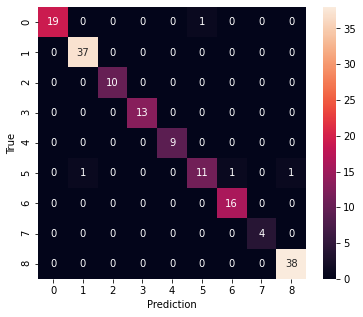

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5])
sns.heatmap(confusion_matrix(arr_truth, arr_pred), annot=True, ax=ax, fmt='.20g')
ax.set_xlabel('Prediction')
ax.set_ylabel('True')